Install and Import necessary packages

In [54]:
#!conda run pip install rpy2
#!conda run pip install pytensor
#!pip install pingouin
#!conda run pip install pandas
#!conda run pip install statsmodels
#!conda run pip install bambi
#!conda run pip install ipywidgets

In [2]:

import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import bambi as bmb
import arviz as az
import pickle

# Import the data

In [ ]:
#selected 
with open('data/df_ccSolve_analysis.pkl', 'rb') as f:
    df_ccSolve = pickle.load(f)


In [7]:
print(df_ccSolve.columns)

Index(['dem_male', 'dem_educ', 'dem_age', 'dem_race', 'dem_latino',
       'dem_income', 'pol_party', 'pol_lean', 'dem_stcount_1', 'WAVE',
       'pol_score', 'log_income_median', 'educ_adv', 'dem_male_simp',
       'high_income', 'ccSolve_support_givenCost', 'ccSolve_cost',
       'ccSolve_signlogCost'],
      dtype='object')


In [8]:
# Get distributions of all columns in the dataframe, handling numeric, boolean, and categorical/object types
columns_to_check = ['high_income','pol_score','dem_male_simp','dem_age','educ_adv']
for col in columns_to_check:
    print(f"\n--- Distribution for '{col}' ---")
    col_data = df_ccSolve[col]
    if pd.api.types.is_bool_dtype(col_data):
        print(col_data.value_counts(dropna=False))
    elif pd.api.types.is_numeric_dtype(col_data):
        print(col_data.describe())
    else:
        print(col_data.value_counts(dropna=False))


--- Distribution for 'high_income' ---
high_income
0    7738
1    2967
Name: count, dtype: int64

--- Distribution for 'pol_score' ---
count    10705.000000
mean        -0.146007
std          1.677101
min         -2.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max          2.000000
Name: pol_score, dtype: float64

--- Distribution for 'dem_male_simp' ---
dem_male_simp
False    5739
True     4966
Name: count, dtype: int64

--- Distribution for 'dem_age' ---
count    10705.000000
mean        49.076600
std         17.065586
min         18.000000
25%         35.000000
50%         49.000000
75%         64.000000
max         99.000000
Name: dem_age, dtype: float64

--- Distribution for 'educ_adv' ---
educ_adv
False    9140
True     1565
Name: count, dtype: int64


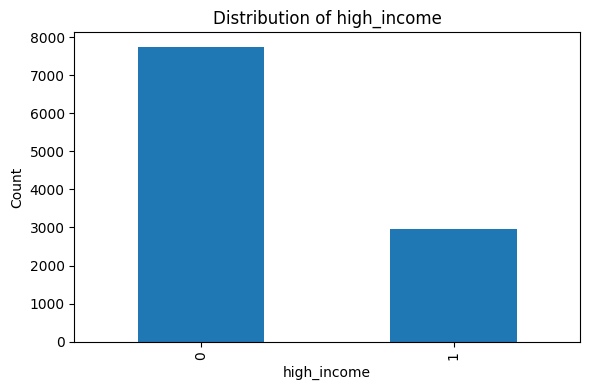

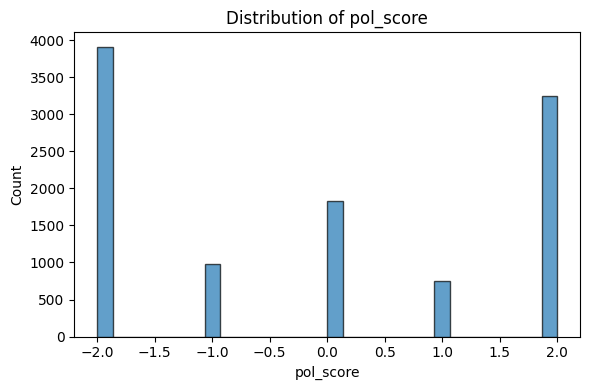

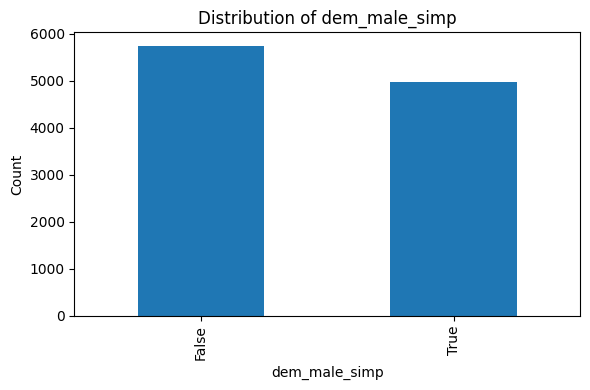

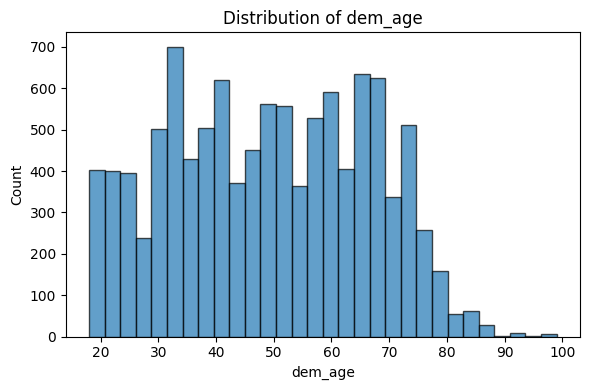

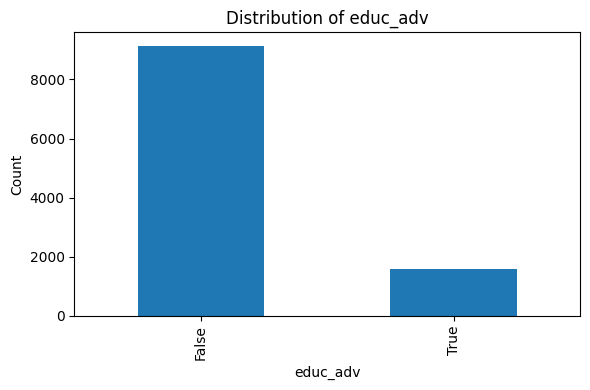

In [9]:
for col in columns_to_check:
    plt.figure(figsize=(6, 4))
    col_data = df_ccSolve[col]
    if pd.api.types.is_numeric_dtype(col_data):
        plt.hist(col_data.dropna(), bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col}")
    else:
        col_data.value_counts(dropna=False).plot(kind='bar')
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Data exploration

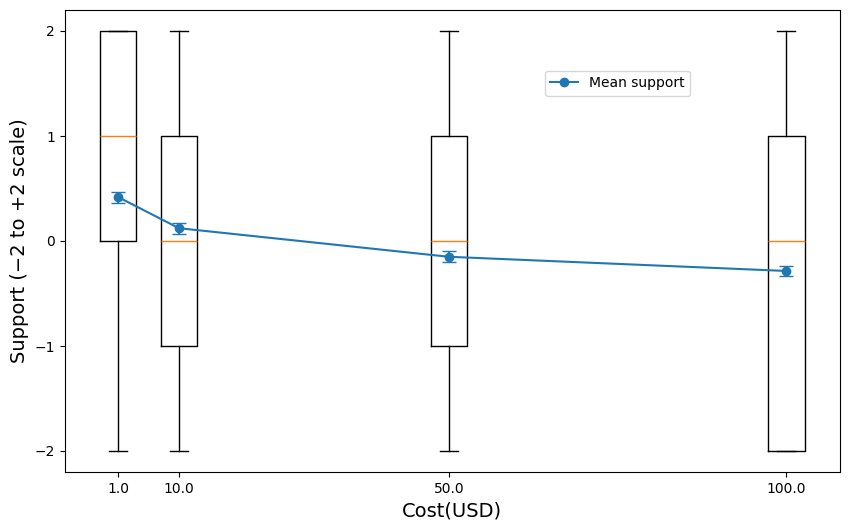

In [10]:
dataframe=df_ccSolve
topic='ccSolve'

# 1) Sort unique ccSolve/ccComp costs
solve_costs = np.sort(dataframe[topic+'_cost'].unique())

# 2) Prepare data arrays for each cost
solve_data = [
    dataframe.loc[dataframe[topic+'_cost'] == c, topic+'_support_givenCost'].values
    for c in solve_costs
]

# 3) Compute mean and ±2×SEM for each cost
grouped = dataframe.groupby(topic+'_cost')[topic+'_support_givenCost']
mean_support = grouped.mean().reindex(solve_costs).values
sem_support = 2 * grouped.sem().reindex(solve_costs).values

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplot at numeric cost positions
width = (solve_costs[1] - solve_costs[0]) * 0.6 if len(solve_costs) > 1 else 0.6
ax.boxplot(solve_data, positions=solve_costs, widths=width)

# Overlay mean support connected by a line
ax.plot(solve_costs, mean_support, marker='o', linestyle='-',
        label='Mean support', zorder=3)

# Add error bars (±2 SEM) in the same blue
ax.errorbar(solve_costs, mean_support, yerr=sem_support,
            fmt='none', capsize=5, zorder=2)

# Place the legend at (75, 1.5) in data coordinates
leg = ax.legend(loc='center', 
                bbox_to_anchor=(75, 1.5),
                bbox_transform=ax.transData)
leg.get_frame().set_alpha(0.8)
leg.get_frame().set_facecolor('white')

# 5) Y‑axis ticks at integers and gridlines there
ax.set_yticks(np.arange(-2, 3, 1))
#ax.grid(axis='y', which='major')

# Labels and styling
ax.set_xlabel('Cost(USD)',fontsize=14)
ax.set_ylabel('Support (−2 to +2 scale)',fontsize=14)
#ax.set_title('Support for '+topic+ ' by Cost with Mean ± 2 SEM')
ax.set_xticks(solve_costs)
fig.savefig(f'cost_repsonse.png', dpi=400, bbox_inches='tight')
plt.show()


In [11]:
#Check size of the dataframe
print(f"Size of the dataframe: {dataframe.shape}")

Size of the dataframe: (10705, 18)


### Run linear regression analysis

In [21]:
dataframe=df_ccSolve
topic='ccSolve'

#Run regressions
results = {}

# (1a) Cost-only: cost
results['cost_only'] = smf.ols(topic+'_support_givenCost ~ '+topic+'_cost', data=dataframe).fit()

# (1b1) Add income (categorical)
results['cost + C(income)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(dem_income)', data=dataframe
).fit()

# (1b2) Add continuous log income (continuous median)
results['cost + income_num'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + log_income_median', data=dataframe
).fit()

# (1b3) Add category of high income
results['cost + high_income'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(high_income)', data=dataframe
).fit()

# (1c1) Add partisanship (categorical)
results['cost + C(party)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(pol_party)', data=dataframe
).fit()

# (1c2) Add partisanship (continuous score)
results['cost + pol_score'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + pol_score', data=dataframe
).fit()

# (1d1) Add education (categorical)
results['cost + C(educ)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(dem_educ)', data=dataframe
).fit()

# (1d2) Add education (categorical simplified)
results['cost + C(adv_educ)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(educ_adv)', data=dataframe
).fit()

# (1e1) Add gender (categorical)
results['cost + C(gender)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(dem_male)', data=dataframe
).fit()

# (1e1) Add gender (categorical)
results['cost + C(male)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_cost + C(dem_male_simp)', data=dataframe
).fit()


# (1f1) Full model with demographics and categoricals that were doing better in isolation
formula_full = topic+'_support_givenCost ~ '+topic+'_cost + C(dem_income) + pol_score + C(dem_male_simp) + dem_age + C(dem_educ)' 
results['cost_full_cat'] = smf.ols(formula_full, data=dataframe).fit()

# (1f2) Full model with demographics and categoricals that were doing better in isolation
formula_full = topic+'_support_givenCost ~ '+topic+'_cost * pol_score + C(dem_income) + C(dem_male) + dem_age + C(dem_educ)'
results['cost_full_interaction_cat'] = smf.ols(formula_full, data=dataframe).fit()


# (1f1) Full model with demographics
formula_full = topic+'_support_givenCost ~ '+topic+'_cost + C(high_income) + pol_score + C(dem_male_simp) + dem_age + C(educ_adv)' 
results['cost_full'] = smf.ols(formula_full, data=dataframe).fit()

# (1f2) Full model with demographics
formula_full = topic+'_support_givenCost ~ '+topic+'_cost * pol_score * C(high_income) + C(dem_male) + dem_age + C(educ_adv)'
results['cost_full_interaction'] = smf.ols(formula_full, data=dataframe).fit()



# (2a) signlogCost-only: signlogCost
results['signlogCost_only'] = smf.ols(topic+'_support_givenCost ~ '+topic+'_signlogCost', data=dataframe).fit()

# (2b1) Add income (categorical)
results['signlogCost + C(income)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(dem_income)', data=dataframe
).fit()

# (2b2) Add continuous log income (continuous median)
results['signlogCost + income_num'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + log_income_median', data=dataframe
).fit()

# (2c1) Add partisanship (categorical)
results['signlogCost + C(party)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(pol_party)', data=dataframe
).fit()

# (2c2) Add partisanship (continuous score)
results['signlogCost + pol_score'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + pol_score', data=dataframe
).fit()

# (2d1) Add education (categorical)
results['signlogCost + C(educ)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(dem_educ)', data=dataframe
).fit()

# (2d2) Add education (categorical simplified)
results['signlogCost + C(adv_educ)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(educ_adv)', data=dataframe
).fit()

# (2e1) Add gender (categorical)
results['signlogCost + C(gender)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(dem_male)', data=dataframe
).fit()

# (2e1) Add gender (categorical)
results['signlogCost + C(male)'] = smf.ols(
    topic+'_support_givenCost ~ '+topic+'_signlogCost + C(dem_male_simp)', data=dataframe
).fit()


# (2f1) Full model with demographics and categoricals that were doing better in isolation
formula_full = topic+'_support_givenCost ~ '+topic+'_signlogCost + C(dem_income) + pol_score + C(dem_male_simp) + dem_age + C(dem_educ)' 
results['signlogCost_full_cat'] = smf.ols(formula_full, data=dataframe).fit()

# (2f2) Full model with demographics and categoricals that were doing better in isolation
formula_full = topic+'_support_givenCost ~ '+topic+'_signlogCost * pol_score + C(dem_income) + C(dem_male) + dem_age + C(dem_educ)'
results['signlogCost_full_interaction_cat'] = smf.ols(formula_full, data=dataframe).fit()

# (2f1) Full model with demographics
formula_full = topic+'_support_givenCost ~ '+topic+'_signlogCost + C(high_income) + pol_score + C(dem_male_simp) + dem_age + C(educ_adv)' 
results['csignlogCost_full'] = smf.ols(formula_full, data=dataframe).fit()

# (2f2) Full model with demographics
formula_full = topic+'_support_givenCost ~ '+topic+'_signlogCost * pol_score * C(high_income) + C(dem_male) + dem_age + C(educ_adv)'
results['signlogCost_full_interaction'] = smf.ols(formula_full, data=dataframe).fit()



# Print summaries
for name, res in results.items():
    print(f"\n===== Model: {name} =====")
    print(res.summary())


===== Model: cost_only =====
                                OLS Regression Results                               
Dep. Variable:     ccSolve_support_givenCost   R-squared:                       0.032
Model:                                   OLS   Adj. R-squared:                  0.032
Method:                        Least Squares   F-statistic:                     358.3
Date:                       Tue, 27 May 2025   Prob (F-statistic):           1.27e-78
Time:                               11:26:56   Log-Likelihood:                -18368.
No. Observations:                      10705   AIC:                         3.674e+04
Df Residuals:                          10703   BIC:                         3.676e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### Run ordinal regression (bayesian)

In [22]:
# Data
dataframe = df_ccSolve
topic = 'ccSolve'


# Shift the support variable so that the lowest category is 0
dataframe[topic+"_support_givenCost_shifted"] = dataframe[topic+"_support_givenCost"] + 2

# Convert outcome to an ordered categorical (starting at 0)
dataframe['ccSolve_support_givenCost'] = pd.Categorical(
    dataframe['ccSolve_support_givenCost'],
    ordered=True
)

# setting categorical variables (likely not necessary, but just in case)
cat_vars = ['dem_income', 'high_income', 'pol_party', 'dem_educ', 'educ_adv', 'dem_male', 'dem_male_simp','WAVE','dem_stcount_1']
for var in cat_vars:
    dataframe[var] = dataframe[var].astype('category')

In [23]:
def run_bambi(formula, data, family="cumulative",
    draws=750, tune=750,
    chains=12, cores=12,
    target_accept=0.9,
    init="adapt_diag",
    n_init=50000,
    posterior_predictive=True,
    idata_kwargs={"log_likelihood": True}
):
    model = bmb.Model(formula=formula, data=data, family=family)
    idata = model.fit(draws=draws, tune=tune,
        chains=chains, cores=cores,
        target_accept=target_accept,
        init=init, n_init=n_init,
        posterior_predictive=posterior_predictive, idata_kwargs=idata_kwargs
    )
    return model, idata

In [24]:
# Where we save results
results = {}
model = {}


# # (1a) Cost-only
# model['cost_only'], results['cost_only'] = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost", dataframe)

# # (1b) Add demographics one by one
# model['cost + C(income)'], results['cost + C(income)']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + dem_income", dataframe)
# #model['cost + income_num'], results['cost + income_num']    = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + log_income_median", dataframe)
# model['cost + high_income'], results['cost + high_income']  = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + high_income", dataframe)
# model['cost + C(party)'],results['cost + C(party)']         = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + pol_party", dataframe)
# model['cost + pol_score'], results['cost + pol_score']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + pol_score", dataframe)
# model['cost + C(educ)'], results['cost + C(educ)']          = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + dem_educ", dataframe)
# model['cost + C(adv_educ)'], results['cost + C(adv_educ)']  = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + educ_adv", dataframe)
# model['cost + C(gender)'], results['cost + C(gender)']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + dem_male", dataframe)
# model['cost + C(male)'], results['cost + C(male)']          = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + dem_male_simp", dataframe)

# model['cost_full_cat'], results['cost_full_cat']            = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + dem_income + pol_score + dem_male_simp + dem_age + dem_educ", dataframe)
# model['cost_full'], results['cost_full']                    = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + high_income + pol_score + dem_male_simp + dem_age + educ_adv", dataframe)
# model['cost_full_interaction_cat'], results['cost_full_interaction_cat']    = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost * pol_score + dem_income + dem_male + dem_age + dem_educ", dataframe, init="adapt_diag")
# model['cost_full_interaction'], results['cost_full_interaction']            = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost * pol_score * high_income + dem_male + dem_age + educ_adv", dataframe, init="adapt_diag")

# model['cost_full_mixed'], results['cost_full_mixed']                    = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + high_income + pol_score + dem_male_simp + dem_age + educ_adv + (1 | WAVE) + (1 | dem_stcount_1)", dataframe)

# model['cost_full_mixedState'], results['cost_full_mixedState'] = run_bambi(f"{topic}_support_givenCost ~ {topic}_cost + high_income + pol_score + dem_male_simp + dem_age + educ_adv + (1 | dem_stcount_1)", dataframe, init="adapt_diag")

# # (2a) SignLogCost-only
# model['signlogCost_only'], results['signlogCost_only'] = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost", dataframe)

# # (2b) Add demographics one by one
# model['signlogCost + C(income)'], results['signlogCost + C(income)']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + dem_income", dataframe)
# #model['signlogCost + income_num'], results['signlogCost + income_num']    = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + log_income_median", dataframe)
# model['signlogCost + high_income'], results['signlogCost + high_income']  = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + high_income", dataframe)
# model['signlogCost + C(party)'],results['signlogCost + C(party)']         = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + pol_party", dataframe)
# model['signlogCost + pol_score'], results['signlogCost + pol_score']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + pol_score", dataframe)
# model['signlogCost + C(educ)'], results['signlogCost + C(educ)']          = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + dem_educ", dataframe)
# model['signlogCost + C(adv_educ)'], results['signlogCost + C(adv_educ)']  = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + educ_adv", dataframe)
# model['signlogCost + C(gender)'], results['signlogCost + C(gender)']      = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + dem_male", dataframe)
# model['signlogCost + C(male)'], results['signlogCost + C(male)']          = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + dem_male_simp", dataframe)

# model['signlogCost_full_cat'], results['signlogCost_full_cat']            = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + dem_income + pol_score + dem_male_simp + dem_age + dem_educ", dataframe)
model['signlogCost_full'], results['signlogCost_full']                    = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + high_income + pol_score + dem_male_simp + dem_age + educ_adv", dataframe)
# model['signlogCost_full_interaction_cat'], results['signlogCost_full_interaction_cat']    = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost * pol_score + dem_income + dem_male + dem_age + dem_educ", dataframe, init="adapt_diag")
# model['signlogCost_full_interaction'], results['signlogCost_full_interaction']            = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost * pol_score * high_income + dem_male + dem_age + educ_adv", dataframe, init="adapt_diag")

# model['signlogCost_full_mixed'], results['signlogCost_full_mixed']                    = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + high_income + pol_score + dem_male_simp + dem_age + educ_adv + (1 | WAVE) + (1 | dem_stcount_1)", dataframe, init="adapt_diag")

# model['signlogCost_full_mixedState'], results['signlogCost_full_mixedState'] = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + high_income + pol_score + dem_male_simp + dem_age + educ_adv + (1 | dem_stcount_1)", dataframe, init="adapt_diag")

c:\Users\dmittal\OneDrive - UvA\Desktop\Optimal incentives\OneDrive_1_5-16-2025\.conda\Lib\site-packages\bambi\formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Initializing NUTS using adapt_diag...
c:\Users\dmittal\OneDrive - UvA\Desktop\Optimal incentives\OneDrive_1_5-16-2025\.conda\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-conf

Output()

Sampling 12 chains for 750 tune and 750 draw iterations (9_000 + 9_000 draws total) took 443 seconds.


In [25]:
# df_ccSolve.to_pickle("df_ccSolve_analysis.pkl")
# df_ccSolve.to_pickle("df_ccSolve_analysis.pkl")
# Load from file
# with open("results_10b.pkl", "rb") as f:
#     results = pickle.load(f)
#with open("model_10b.pkl", "rb") as f:
#    model = pickle.load(f)
#df_ccSolve.to_pickle("df_ccSolve_analysis.pkl")
print(model)

{'signlogCost_full':        Formula: ccSolve_support_givenCost ~ ccSolve_signlogCost + high_income + pol_score + dem_male_simp + dem_age + educ_adv
        Family: cumulative
          Link: p = logit
  Observations: 10705
        Priors: 
    target = p
        Common-level effects
            ccSolve_signlogCost ~ Normal(mu: 0.0, sigma: 1.6583)
            high_income ~ Normal(mu: 0.0, sigma: 5.5854)
            pol_score ~ Normal(mu: 0.0, sigma: 1.4907)
            dem_male_simp ~ Normal(mu: 0.0, sigma: 5.0131)
            dem_age ~ Normal(mu: 0.0, sigma: 0.1465)
            educ_adv ~ Normal(mu: 0.0, sigma: 7.0761)
        
        Auxiliary parameters
            threshold ~ Normal(mu: [-2.   -0.67  0.67  2.  ], sigma: 1.0, transform: ordered)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()}


In [26]:
def summarize_significance_strong(idata):
    """
    Summarize posterior parameters with stars based on strong HDI exclusion of zero.
    * = 95% HDI
    ** = 99% HDI
    *** = 99.9% HDI
    Thresholds are included but never starred.
    """
    import numpy as np
    import pandas as pd
    import arviz as az

    summary_95 = az.summary(idata, hdi_prob=0.95)
    summary_99 = az.summary(idata, hdi_prob=0.99)
    summary_999 = az.summary(idata, hdi_prob=0.999)

    # Get HDI columns dynamically
    hdi95_lower, hdi95_upper = [col for col in summary_95.columns if "hdi_" in col]
    hdi99_lower, hdi99_upper = [col for col in summary_99.columns if "hdi_" in col]
    hdi999_lower, hdi999_upper = [col for col in summary_999.columns if "hdi_" in col]

    rows = []

    for param in summary_95.index:
        mean = summary_95.loc[param, "mean"]
        sd = summary_95.loc[param, "sd"]

        hdi95 = (summary_95.loc[param, hdi95_lower], summary_95.loc[param, hdi95_upper])
        hdi99 = (summary_99.loc[param, hdi99_lower], summary_99.loc[param, hdi99_upper])
        hdi999 = (summary_999.loc[param, hdi999_lower], summary_999.loc[param, hdi999_upper])

        if param.startswith("threshold"):
            # Thresholds: no stars
            star = ""
        else:
            # Other parameters: assign stars
            if (hdi999[0] > 0) or (hdi999[1] < 0):
                star = "***"
            elif (hdi99[0] > 0) or (hdi99[1] < 0):
                star = "**"
            elif (hdi95[0] > 0) or (hdi95[1] < 0):
                star = "*"
            else:
                star = ""

        rows.append({
            "Parameter": param,
            "Mean": mean,
            "SD": sd,
            "Stars": star
        })

    return pd.DataFrame(rows).set_index("Parameter")

In [27]:
# No row truncation
pd.set_option('display.max_rows', None)
# No column truncation
pd.set_option('display.max_columns', None)
# Make sure full width prints
pd.set_option('display.width', None)
# Avoid any column value truncation
pd.set_option('display.max_colwidth', None)
#pd.set_option("display.float_format", lambda x: f"{x:.6f}")

for name, idata in results.items():
    print(f"\n===== Model: {name} =====")
    print("\n--- Posterior Summary (HDI-based significance) ---")
    print(summarize_significance_strong(idata))
    print("\n--- Model Predictive Performance (LOO-CV) ---")
    print(az.loo(idata))


===== Model: signlogCost_full =====

--- Posterior Summary (HDI-based significance) ---
                      Mean     SD Stars
Parameter                              
threshold[0]        -2.986  0.072      
threshold[1]        -2.268  0.070      
threshold[2]        -0.956  0.067      
threshold[3]         0.366  0.067      
ccSolve_signlogCost -0.270  0.012   ***
high_income[1]       0.380  0.043   ***
pol_score           -0.359  0.011   ***
dem_male_simp[True]  0.274  0.036   ***
dem_age             -0.021  0.001   ***
educ_adv[True]       0.461  0.055   ***

--- Model Predictive Performance (LOO-CV) ---
Computed from 9000 posterior samples and 10705 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15740.85    49.09
p_loo       10.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     10705  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



In [80]:
#if model is not defined, define it
# if 'model' not in locals():
#     model = {}
# name = 'signlogCost_full'

#model[name], results[name] = run_bambi(f"{topic}_support_givenCost ~ {topic}_signlogCost + high_income + pol_score + dem_male_simp + dem_age + educ_adv + (1 | dem_stcount_1)", dataframe, init="adapt_diag")

idata = results[name]
idata.extend(model[name].predict(idata, kind="response", inplace=False))  # `model` must be the original Bambi model
# Save once on your original device
idata.to_netcdf(name+".nc")

'signlogCost_full.nc'

In [28]:
with open("results_10b.pkl", "wb") as f:
   pickle.dump(results, f)

In [29]:
# No row truncation
pd.set_option('display.max_rows', None)
# No column truncation
pd.set_option('display.max_columns', None)
# Make sure full width prints
pd.set_option('display.width', None)
# Avoid any column value truncation
pd.set_option('display.max_colwidth', None)



print(f"\n===== Model: {name} =====")
print("\n--- Posterior Summary (HDI-based significance) ---")
print(summarize_significance_strong(idata))
print("\n--- Model Predictive Performance (LOO-CV) ---")
az.loo(idata)


===== Model: signlogCost_full =====

--- Posterior Summary (HDI-based significance) ---
                      Mean     SD Stars
Parameter                              
threshold[0]        -2.986  0.072      
threshold[1]        -2.268  0.070      
threshold[2]        -0.956  0.067      
threshold[3]         0.366  0.067      
ccSolve_signlogCost -0.270  0.012   ***
high_income[1]       0.380  0.043   ***
pol_score           -0.359  0.011   ***
dem_male_simp[True]  0.274  0.036   ***
dem_age             -0.021  0.001   ***
educ_adv[True]       0.461  0.055   ***

--- Model Predictive Performance (LOO-CV) ---


Computed from 9000 posterior samples and 10705 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15740.85    49.09
p_loo       10.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     10705  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

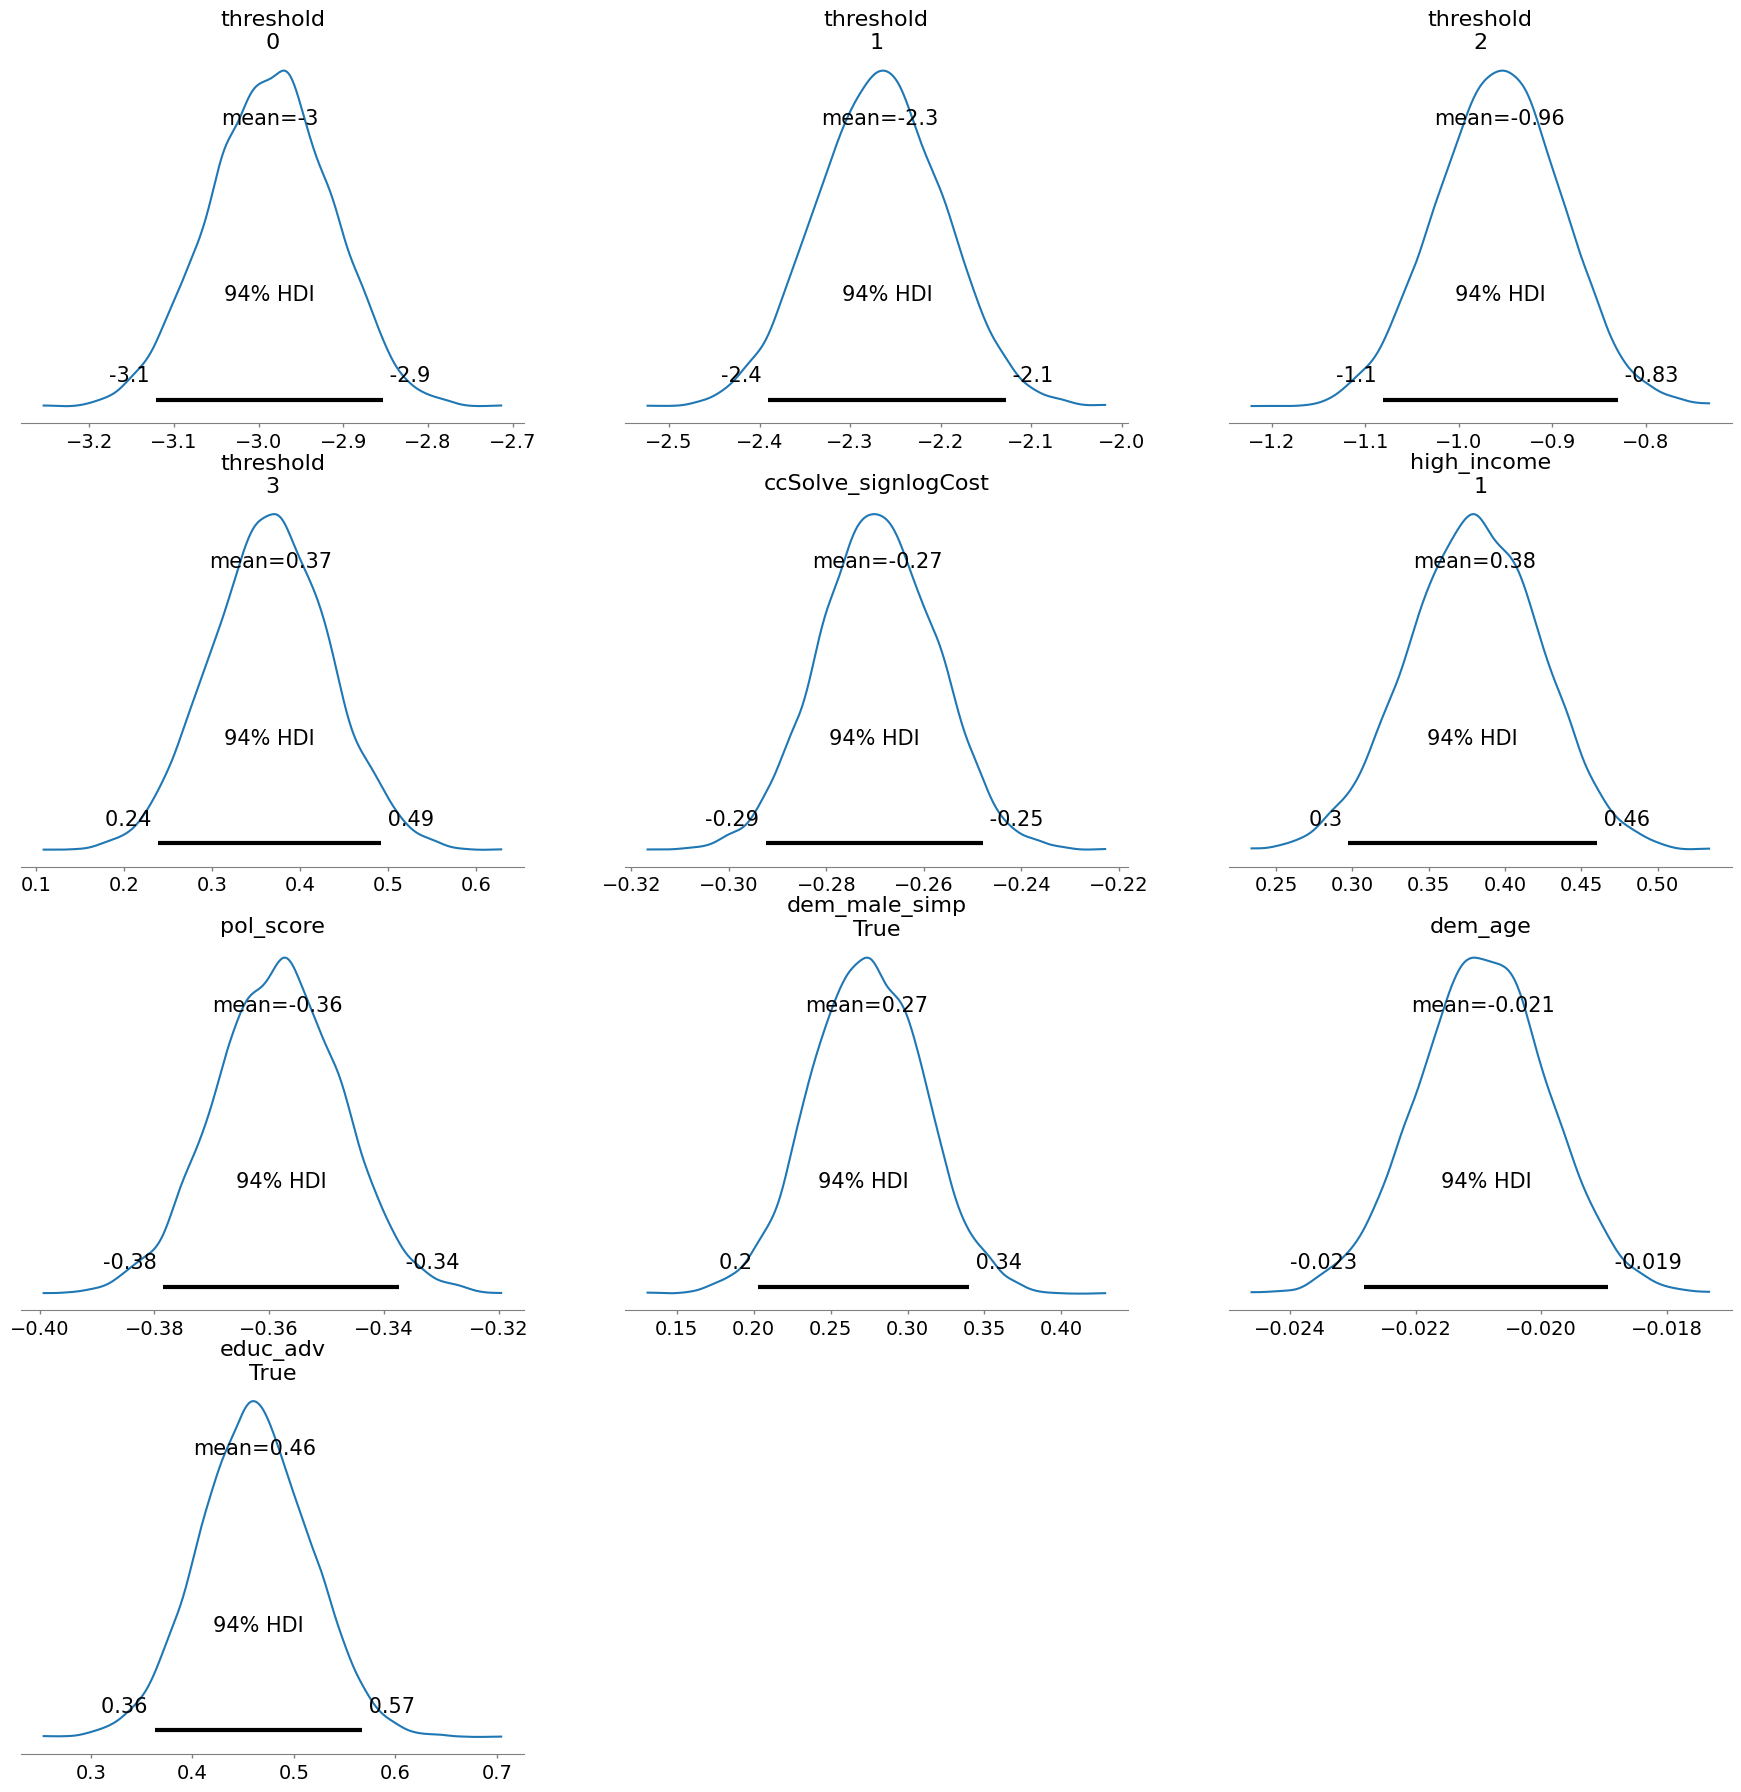

In [30]:
az.rcParams["plot.max_subplots"] = 62
az.plot_posterior(idata);

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-2.986,0.072,-3.121,-2.852,0.001,0.001,4074.0,5761.0,1.0
threshold[1],-2.268,0.070,-2.391,-2.128,0.001,0.001,4391.0,6061.0,1.0
threshold[2],-0.956,0.067,-1.081,-0.830,0.001,0.001,4875.0,5929.0,1.0
threshold[3],0.366,0.067,0.238,0.492,0.001,0.001,5555.0,6554.0,1.0
ccSolve_signlogCost,-0.270,0.012,-0.292,-0.248,0.000,0.000,7488.0,6942.0,1.0
high_income[1],0.380,0.043,0.297,0.460,0.000,0.000,8071.0,6803.0,1.0
pol_score,-0.359,0.011,-0.378,-0.337,0.000,0.000,9484.0,7235.0,1.0
dem_male_simp[True],0.274,0.036,0.203,0.340,0.000,0.000,9257.0,6684.0,1.0
dem_age,-0.021,0.001,-0.023,-0.019,0.000,0.000,5805.0,6239.0,1.0
educ_adv[True],0.461,0.055,0.363,0.568,0.001,0.001,9282.0,6771.0,1.0


In [34]:
az.loo(idata)

Computed from 9000 posterior samples and 10705 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15740.85    49.09
p_loo       10.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     10705  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

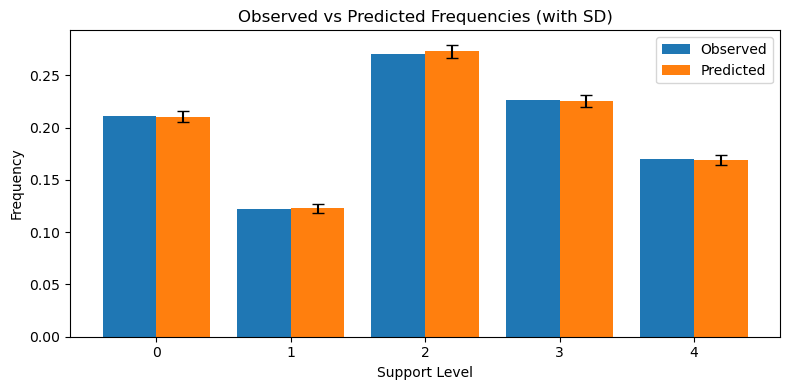

In [ ]:
# 1. Stack the predictions (samples x observations)
pred = idata.posterior_predictive["ccSolve_support_givenCost"]
pred = pred.stack(sample=("chain", "draw"))  # (obs, sample)

# 2. Convert to numpy array and flatten
pred_np = pred.transpose("sample", "__obs__").values.astype(int)  # shape: (n_samples, n_obs)

# 3. Count predictions per category across samples
import pandas as pd
import matplotlib.pyplot as plt

# Compute value counts per sample (axis 0)
df_counts = pd.DataFrame([
    pd.Series(row).value_counts().sort_index()
    for row in pred_np
]).fillna(0)

# Add mean and std for each support level
summary = df_counts.mean().to_frame("mean")
summary["std"] = df_counts.std()

# 4. Plot it
observed = idata.observed_data["ccSolve_support_givenCost"].values
obs_counts = pd.Series(observed).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
x = summary.index
ax.bar(x - 0.2, obs_counts.loc[x] / obs_counts.sum(), width=0.4, label="Observed")
ax.bar(x + 0.2, summary["mean"] / pred_np.shape[1], yerr=summary["std"] / pred_np.shape[1], 
       width=0.4, label="Predicted", capsize=4)

ax.set_xticks(x)
ax.set_xlabel("Support Level")
ax.set_ylabel("Frequency")
ax.set_title("Observed vs Predicted Frequencies (with SD)")
ax.legend()
plt.tight_layout()
plt.show()


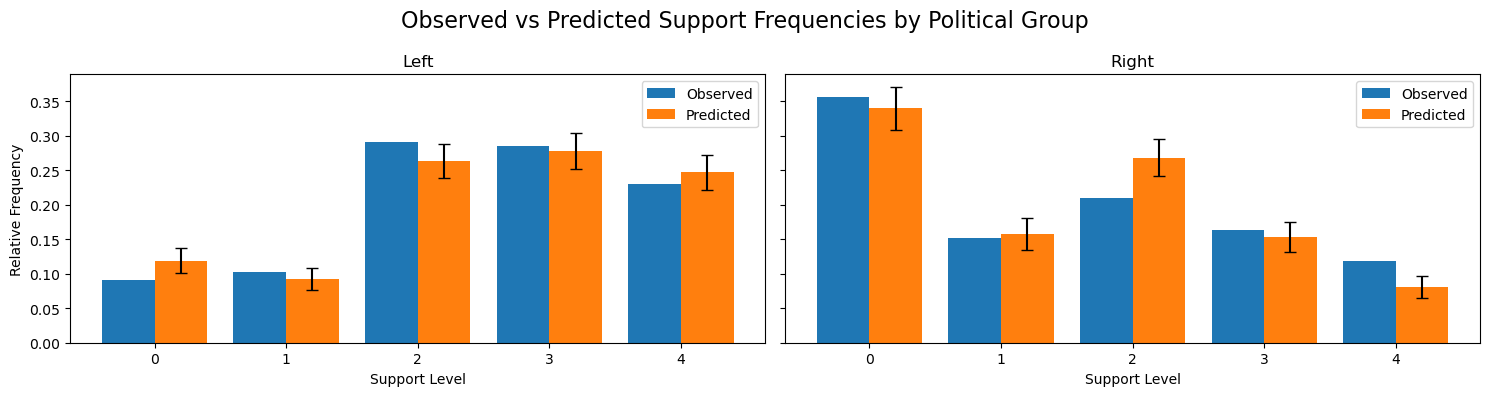

In [ ]:
# 1. Align original dataframe to idata observations
obs_idx = idata.observed_data["ccSolve_support_givenCost"].coords["__obs__"].values
df_cov = dataframe.iloc[obs_idx].copy().reset_index(drop=True)

# 2. Add pol_group (Left / Center / Right)
df_cov["pol_group"] = df_cov["pol_score"].apply(
    lambda x: "Left" if x == -2 else "Right" if x == 2 else np.nan
)
df_cov = df_cov.dropna(subset=["pol_group"])

# 3. Stack posterior predictive into (sample, obs) shape
pred = idata.posterior_predictive["ccSolve_support_givenCost"]
pred_stacked = pred.stack(sample=("chain", "draw")).transpose("sample", "__obs__").values.astype(int)

# 4. Extract observed
observed = idata.observed_data["ccSolve_support_givenCost"].values

# 5. Loop through groups and compute observed + predicted distributions
results = []
groups = ["Left", "Center", "Right"]

for group in groups:
    idx = df_cov[df_cov["pol_group"] == group].index.tolist()
    if not idx:
        continue
    
    obs_group = observed[idx]
    pred_group = pred_stacked[:, idx]  # shape (samples, n_group_obs)
    
    # Count observed frequency
    obs_freq = pd.Series(obs_group).value_counts().sort_index()

    # Count predicted frequency per sample
    pred_freqs = pd.DataFrame([
        pd.Series(row).value_counts().sort_index()
        for row in pred_group
    ]).fillna(0)

    # Normalize
    obs_freq_norm = obs_freq / obs_freq.sum()
    pred_mean = pred_freqs.mean() / pred_group.shape[1]
    pred_std = pred_freqs.std() / pred_group.shape[1]
    
    results.append((group, obs_freq_norm, pred_mean, pred_std))

# 6. Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

for ax, (group, obs, pred, std) in zip(axes, results):
    support_levels = sorted(set(obs.index) | set(pred.index))
    obs_vals = obs.reindex(support_levels, fill_value=0)
    pred_vals = pred.reindex(support_levels, fill_value=0)
    std_vals = std.reindex(support_levels, fill_value=0)

    x = np.arange(len(support_levels))
    ax.bar(x - 0.2, obs_vals, width=0.4, label="Observed")
    ax.bar(x + 0.2, pred_vals, width=0.4, yerr=3*std_vals, capsize=4, label="Predicted")

    ax.set_title(f"{group}")
    ax.set_xticks(x)
    ax.set_xticklabels(support_levels)
    ax.set_xlabel("Support Level")
    if ax == axes[0]:
        ax.set_ylabel("Relative Frequency")
    ax.legend()

fig.suptitle("Observed vs Predicted Support Frequencies by Political Group", fontsize=16)
plt.tight_layout()
plt.show()

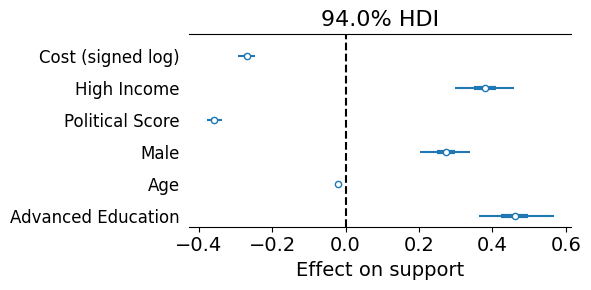

In [42]:
label_map = {
    topic + "_signlogCost": "Cost (signed log)",
    "high_income": "High Income",
    "pol_score": "Political Score",
    "dem_male_simp": "Male",
    "dem_age": "Age",
    "educ_adv": "Advanced Education"
}

# Use a list comprehension to map names
pretty_labels = [label_map.get(var, var) for var in [topic+"_signlogCost", "high_income", "pol_score", "dem_male_simp", "dem_age", "educ_adv"]][::-1]

fig, ax = plt.subplots(figsize=(6, 3))
az.plot_forest(
    idata,
    var_names=[topic+"_signlogCost", "high_income", "pol_score", "dem_male_simp", "dem_age", "educ_adv"],
    ax=ax,
    combined=True,
    model_names=[""],
    kind="forestplot",
    ridgeplot_alpha=0,
)
ax.set_yticklabels(pretty_labels, fontsize=12)
ax.axvline(0, color="black", linestyle="--")
ax.set_xlabel("Effect on support", fontsize=14)
plt.tight_layout()
fig.savefig("forest_plot.png", dpi=400, bbox_inches='tight')

plt.show()

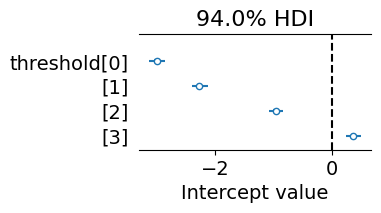

In [53]:
fig, ax = plt.subplots(figsize=(3, 1.5))
az.plot_forest(idata, var_names=["threshold"],ax=ax, combined=True);
ax.axvline(0, color="black", linestyle="--")
ax.set_xlabel("Intercept value",fontsize=14)
fig.savefig("forest_plot_threshold.png", dpi=400, bbox_inches='tight')

#### Compute willingess to pay for a given model

In [30]:
def break_even_cost(profile, cost_var="ccSolve_signlogCost", post=None, model_path="signlogCost_full.nc"):
    """
    Computes break-even cost for a given profile using a stored posterior model.

    Parameters
    ----------
    profile : dict
        Dictionary of covariate names and their values (must match model names).
    cost_var : str
        Name of the variable for cost sensitivity.
    post : xarray.Dataset or None
        Posterior samples. If None, loads from model_path.
    model_path : str
        Path to the .nc file to load if post is not given.

    Returns
    -------
    pd.DataFrame
        DataFrame with one column 'cost_star' and posterior draws.
    """
    if post is None:
        post = az.from_netcdf(model_path).posterior

    # Parameters
    beta_cost = post[cost_var]
    thresholds = post["threshold"]
    alpha1 = thresholds.sel(threshold_dim=1)
    alpha2 = thresholds.sel(threshold_dim=2)
    eta_target = 0.5 * (alpha1 + alpha2)

    # Fixed component
    eta_fixed = 0
    for name, value in profile.items():
        if name in post.data_vars:
            eta_fixed += post[name] * value

    signlog_cost_star = (eta_target - eta_fixed) / beta_cost
    cost_star = np.sign(signlog_cost_star) * (np.exp(np.abs(signlog_cost_star))-1)

    return cost_star.to_dataframe(name="cost_star").reset_index()

In [31]:
# Example
profile = {
    "high_income[1]": 0,
    "pol_score": 0.0,
    "dem_male_simp[True]": 1,
    "dem_age": 45,
    "educ_adv[True]": 0
}

# Just call:
df_mid = break_even_cost(profile)

# Summarize
print(df_mid.cost_star.median())
print(df_mid.cost_star.quantile([0.025, 0.975]))


11.04474255615975
0.025     8.948164
0.975    13.550229
Name: cost_star, dtype: float64


In [32]:
def compute_break_even_for_row(row):
    profile = {
        "high_income[1]": row["high_income"],    # 0 or 1
        "pol_score": row["pol_score"],            # float or int
        "dem_male_simp[True]": int(row["dem_male_simp"]),  # convert True/False to 1/0
        "dem_age": row["dem_age"],                # int
        "educ_adv[True]": int(row["educ_adv"])     # convert True/False to 1/0
    }
    df_cost = break_even_cost(profile)
    return df_cost["cost_star"].median()


In [ ]:
from joblib import Parallel, delayed
# Load posterior ONCE outside the function
post = az.from_netcdf("signlogCost_full.nc").posterior

with open('data/df_ccsolve_analysis.pkl', 'rb') as f:
    dataframe = pickle.load(f)
# Redefine the row-wise function using the preloaded `post`
def compute_break_even_for_row_joblib(row):
    profile = {
        "high_income[1]": row["high_income"],
        "pol_score": row["pol_score"],
        "dem_male_simp[True]": int(row["dem_male_simp"]),
        "dem_age": row["dem_age"],
        "educ_adv[True]": int(row["educ_adv"])
    }
    df_cost = break_even_cost(profile, post=post)
    return df_cost["cost_star"].median()

# Convert to list of dicts (records) for joblib-friendly input
rows = dataframe.to_dict(orient="records")

# Run in parallel using joblib with 16 workers
results = Parallel(n_jobs=16, backend="loky")(
    delayed(compute_break_even_for_row_joblib)(row) for row in rows
)

# Assign results back to DataFrame
dataframe["break_even_cost_median"] = results

C:\Users\dmittal\AppData\Local\Temp\ipykernel_19204\1865836939.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataframe = pickle.load(f)


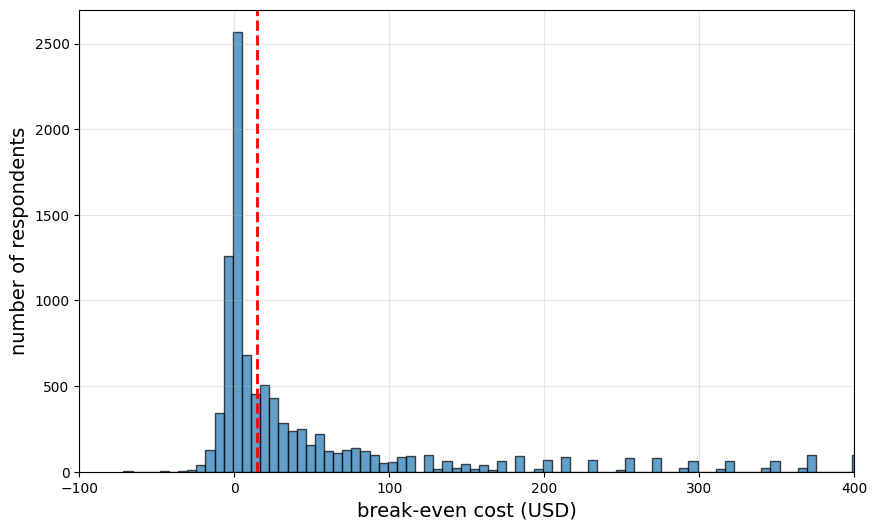

14.534981988897115
0.025    -10.243064
0.975    948.987688
Name: break_even_cost_median, dtype: float64
104.41969230009953


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(dataframe["break_even_cost_median"], bins=250, edgecolor='black', alpha=0.7)
plt.axvline(dataframe["break_even_cost_median"].median(), color='red', linestyle='dashed', linewidth=2)
#plt.title("histogram of break-even Costs", fontsize=16)
plt.xlabel("break-even cost (USD)", fontsize=14)
plt.ylabel("number of respondents", fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(-100, 400)
plt.show()
#print statistics
print("Break-even cost statistics:")    
print("Median:", dataframe["break_even_cost_median"].median())
print("Quantiles (2.5%, 97.5%):", dataframe["break_even_cost_median"].quantile([0.025, 0.975]))
print("Mean:", dataframe["break_even_cost_median"].mean())
